## __PytorchでCNN__

PyTorchを用いてCNNでMNISTデータの多値分類を行う

参考 https://github.com/MLHPC/wandb_tutorial

### __準備__

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### __設定__

In [2]:
learning_rate = 0.01
batch_size = 512
epochs = 20
ndigits = 5 # 表示する小数点以下の桁数

### __データの準備__

In [3]:
# transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data",
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    transform=transform,
    download=False
)

# DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### __モデル__

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3) # 入力チャンネル数、出力チャンネル数、カーネルサイズ
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d(2, stride=2) # カーネルサイズ
        self.l1 = nn.Linear(32*12*12, 120) # 入力サイズ、出力サイズ
        self.l2 = nn.Linear(120, 10)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2,
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        y = self.classifier(x)
        return y

In [5]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss() # 損失関数
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # 最適化関数

### __学習__

In [44]:
# 記録
history = {
    "train_acc": [],
    "train_loss": [],
    "test_acc": [],
    "test_loss": [],    
}

for epoch in range(epochs):

    # 学習
    model.train()
    train_acc, train_loss = 0, 0
    for inputs, labels in tqdm(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # 勾配をリセット
        outputs = model(inputs) # 予測
        loss = criterion(outputs, labels) # 損失関数
        loss.backward() # 逆伝播
        optimizer.step() # パラメータの更新   
        pred = outputs.argmax(1)
        train_acc += (pred==labels).sum().item() / len(labels)
        train_loss += loss.item()
    train_acc = round(train_acc / len(train_dataloader), ndigits)
    train_loss = round(train_loss / len(train_dataloader), ndigits)

    # 推論
    model.eval()
    test_acc, test_loss = 0, 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) # 予測
            loss = criterion(outputs, labels) # 損失関数
            pred = outputs.argmax(1)
            test_acc += (pred==labels).sum().item() / len(labels)
            test_loss += loss.item()
        test_acc = round(test_acc / len(test_dataloader), ndigits)
        test_loss = round(test_loss / len(test_dataloader), ndigits)

    # 記録
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    history["test_acc"].append(test_acc)
    history["test_loss"].append(test_loss)
    print(f"{epoch+1}/{epochs}", "train_acc:", train_acc, "train_loss:", train_loss, "test_acc:", test_acc, "test_loss:", test_loss)

  0%|          | 0/118 [00:00<?, ?it/s]

1/20 train_acc: 0.99926 train_loss: 0.0069 test_acc: 0.99924 test_loss: 0.00717


  0%|          | 0/118 [00:00<?, ?it/s]

2/20 train_acc: 0.99902 train_loss: 0.01016 test_acc: 0.99942 test_loss: 0.00397


  0%|          | 0/118 [00:00<?, ?it/s]

3/20 train_acc: 0.99945 train_loss: 0.00492 test_acc: 0.99974 test_loss: 0.00238


  0%|          | 0/118 [00:00<?, ?it/s]

4/20 train_acc: 0.99957 train_loss: 0.00364 test_acc: 0.99962 test_loss: 0.00323


  0%|          | 0/118 [00:00<?, ?it/s]

5/20 train_acc: 0.99962 train_loss: 0.00273 test_acc: 0.99992 test_loss: 0.00088


  0%|          | 0/118 [00:00<?, ?it/s]

6/20 train_acc: 0.99978 train_loss: 0.001 test_acc: 0.9996 test_loss: 0.00343


  0%|          | 0/118 [00:00<?, ?it/s]

7/20 train_acc: 0.99957 train_loss: 0.00421 test_acc: 0.99861 test_loss: 0.01253


  0%|          | 0/118 [00:00<?, ?it/s]

8/20 train_acc: 0.99892 train_loss: 0.01067 test_acc: 0.99914 test_loss: 0.01011


  0%|          | 0/118 [00:00<?, ?it/s]

9/20 train_acc: 0.99945 train_loss: 0.00606 test_acc: 0.99967 test_loss: 0.00273


  0%|          | 0/118 [00:00<?, ?it/s]

10/20 train_acc: 0.99924 train_loss: 0.00669 test_acc: 0.99921 test_loss: 0.00837


  0%|          | 0/118 [00:00<?, ?it/s]

11/20 train_acc: 0.99965 train_loss: 0.00264 test_acc: 0.99954 test_loss: 0.00429


  0%|          | 0/118 [00:00<?, ?it/s]

12/20 train_acc: 0.99906 train_loss: 0.01195 test_acc: 0.99912 test_loss: 0.00721


  0%|          | 0/118 [00:00<?, ?it/s]

13/20 train_acc: 0.99853 train_loss: 0.01809 test_acc: 0.99873 test_loss: 0.01448


  0%|          | 0/118 [00:00<?, ?it/s]

14/20 train_acc: 0.99882 train_loss: 0.01221 test_acc: 0.99944 test_loss: 0.00571


  0%|          | 0/118 [00:00<?, ?it/s]

15/20 train_acc: 0.99876 train_loss: 0.01717 test_acc: 0.99869 test_loss: 0.01545


  0%|          | 0/118 [00:00<?, ?it/s]

16/20 train_acc: 0.99891 train_loss: 0.01273 test_acc: 0.99968 test_loss: 0.00185


  0%|          | 0/118 [00:00<?, ?it/s]

17/20 train_acc: 0.99934 train_loss: 0.00721 test_acc: 0.99916 test_loss: 0.01061


  0%|          | 0/118 [00:00<?, ?it/s]

18/20 train_acc: 0.99897 train_loss: 0.01372 test_acc: 0.99934 test_loss: 0.00707


  0%|          | 0/118 [00:00<?, ?it/s]

19/20 train_acc: 0.99943 train_loss: 0.00563 test_acc: 0.99965 test_loss: 0.00528


  0%|          | 0/118 [00:00<?, ?it/s]

20/20 train_acc: 0.99935 train_loss: 0.00969 test_acc: 0.99959 test_loss: 0.00349


### __学習曲線__

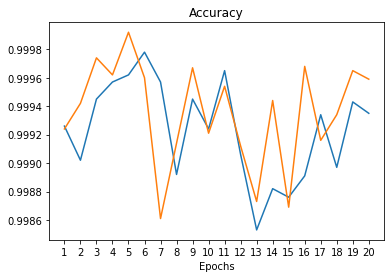

In [47]:
# 正解率
x = range(1, epochs+1)
plt.title("Accuracy")
plt.plot(x, history["train_acc"], label="train")
plt.plot(x, history["test_acc"], label="test")
plt.xlabel("Epochs")
plt.xticks(x)
plt.show()

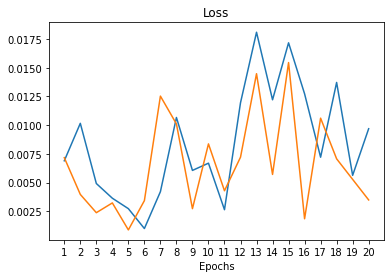

In [48]:
# 損失関数
x = range(1, epochs+1)
plt.title("Loss")
plt.plot(x, history["train_loss"], label="train")
plt.plot(x, history["test_loss"], label="test")
plt.xlabel("Epochs")
plt.xticks(x)
plt.show()

### __推論結果の一部__

In [37]:
inputs = inputs.cpu().numpy() # matplotlibにTensorは代入できないのでndarrayに変換
inputs = inputs.reshape(-1, 28, 28) # チャンネル数の次元を削除

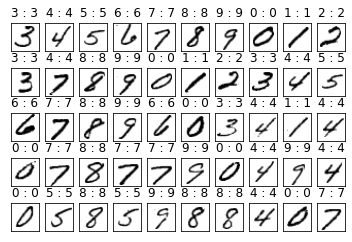

In [38]:
for i in range(50):
    ax = plt.subplot(5, 10, i+1)
    plt.imshow(inputs[i], cmap="gray_r")
    if labels[i] == pred[i]:
        ax.set_title(f"{labels[i]} : {pred[i]}")
    else:
        ax.set_title(f"{labels[i]} : {pred[i]}", fontdict={"color": "r"}) # 誤予測の場合、赤色
    ax.get_xaxis().set_visible(False) # x軸を非表示
    ax.get_yaxis().set_visible(False) # y軸を非表示
plt.show()